Fudan CCDC model (time delay dynamical system):

$$
\begin{aligned}
\frac{\mathrm{d} I}{\mathrm{d} t} &= r I_{0}(t) \\
\frac{\mathrm{d} J}{\mathrm{d} t} &= r \int_{-\infty}^{t} f_{4}(t-s) I_{0}(s) \mathrm{d} s \\
\frac{\mathrm{d} G}{\mathrm{d} t} &= \ell(t) \left[ \int_{-\infty}^{t} f_{2}(t-s) I_{0}(s) d s - \int_{-\infty}^{t} f_{4}(t-s) I_{0}(s) \mathrm{d} s \right] \\
\end{aligned}
$$

- $I(t)$: the cumulative number of the infected at time $t$;

- $J(t)$: the cumulative number of confirmed in hospitalization stage at time $t$;

- $G(t)$: the number of infected and isolated but yet diagnosed cases at time $t$. They are infected in fact, but are not conﬁrmed by the hospital, then not appeared in the infected list of CCDC;

- $I_{0}(t) := I(t) - J(t) - G(t)$: the number of unconfirmed/unobserved infected at time $t$;


<div align="center">
Fudan CCDC's graphical model<br>
<img src="fudanCCDC.png" alt="png" title="Fudan CCDC" width=20%>
</div>

References:

[The reproductive number R0 of COVID-19 based on estimate of a statistical time delay dynamical system][1]

[CoVID-19 in Japan: What could happen in the future?][2]

[Qiita記事: 中国の最新論文の方式で日本のコロナウィルスの感染者数を予測してみた][3]

Data sources:

[厚生労働省: 新型コロナウイルス感染症の現在の状況について（３月８日12時時点版）][4]


[1]:https://www.medrxiv.org/content/10.1101/2020.02.17.20023747v2
[2]:https://www.medrxiv.org/content/10.1101/2020.02.21.20026070v2
[3]:https://qiita.com/KEN_KEN2/items/a1aae5eb4129e5fbd91f
[4]:https://www.mhlw.go.jp/stf/newpage_10032.html


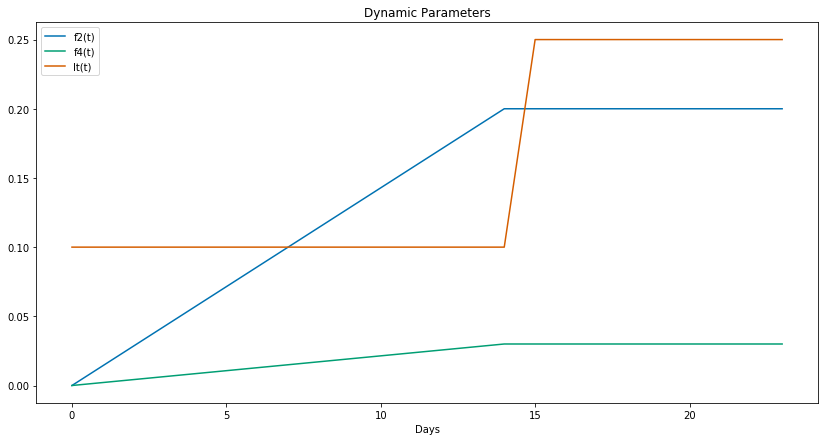

[I 2020-03-08 23:11:18,048] Finished trial#0 resulted in value: 5665.415089293463. Current best value is 5665.415089293463 with parameters: {'isolation_rate': 0.4525640725530966, 'confirmation_rate': 0.010925291249528566}.
[I 2020-03-08 23:17:47,726] Finished trial#1 resulted in value: 122351.92858200292. Current best value is 5665.415089293463 with parameters: {'isolation_rate': 0.4525640725530966, 'confirmation_rate': 0.010925291249528566}.
[I 2020-03-08 23:23:11,445] Finished trial#2 resulted in value: 310781.9155314418. Current best value is 5665.415089293463 with parameters: {'isolation_rate': 0.4525640725530966, 'confirmation_rate': 0.010925291249528566}.
[I 2020-03-08 23:29:06,920] Finished trial#3 resulted in value: 157974.58006833514. Current best value is 5665.415089293463 with parameters: {'isolation_rate': 0.4525640725530966, 'confirmation_rate': 0.010925291249528566}.
[I 2020-03-08 23:34:47,064] Finished trial#4 resulted in value: 162111.67493343944. Current best value is 

best_value =  5665.415089293463
best_params =  {'isolation_rate': 0.4525640725530966, 'confirmation_rate': 0.010925291249528566}


In [1]:
#ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#import packages
import optuna
import numpy as np
import pandas as pd
from ddeint import ddeint
import scipy.integrate as integrate
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')
%matplotlib inline
%load_ext autotime

observation = 'COVID-19.csv'
observed_J = pd.read_csv(observation)

#parameters
t_max = len(observed_J) - 1
growth_rate = 0.31
incidence_rate = 0.2
confirmation_rate = 0.03
isolation_rate = 0.25
J0 = 21 #start day = 2020-02-14
I0 = J0 * 10
G0 = 0
l1 = 0.1
l2 = isolation_rate

#set timespan
tspan = np.linspace(0, t_max, t_max+1)

#dynamic parameters
def states_before_init(t):
    factor = np.exp(-t**2)
    return [I0 * factor, J0 * factor, G0 * factor]

def f2(t):
    return np.minimum(incidence_rate/14 * t, incidence_rate)

def f4(t):
    return np.minimum(confirmation_rate/14 * t, confirmation_rate)

def lt(t):
    return np.where(t < 15, l1, l2)

f2map = map(lambda x: f2(x), tspan)
f4map = map(lambda x: f4(x), tspan)
ltmap = map(lambda x: lt(x), tspan)

#plot dynamic parameters
rcParams['figure.figsize'] = 14, 7
fig, ax = plt.subplots()
ax.plot(tspan, list(f2map))
ax.plot(tspan, list(f4map))
ax.plot(tspan, list(ltmap))
ax.legend(['f2(t)', 'f4(t)', 'lt(t)'])
ax.set_title('Dynamic Parameters')
ax.set_xlabel('Days')
plt.show()

#set differential equation: Fudan CCDC model
def Fudan_CCDC(v, t):
    #I0 at time t must be positive
    I0 = np.maximum(v(t)[0] - v(t)[1] - v(t)[2], 0)
    #I0 at time s must be positive
    Integral2, _ = integrate.quad(lambda s: f2(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)
    Integral4, _ = integrate.quad(lambda s: f4(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)

    dI = growth_rate * I0
    dJ = growth_rate * Integral4
    dG = lt(t) * (Integral2 - Integral4)
    
    return np.array([dI, dJ, dG])

#fitting Fudan CCDC model to the Data
def objective_FudanCCDC(trial):
    global isolation_rate, confirmation_rate
    isolation_rate = trial.suggest_uniform('isolation_rate', 0.1, 0.5)
    confirmation_rate = trial.suggest_loguniform('confirmation_rate', 0.01, 0.1)
    solution = ddeint(Fudan_CCDC, states_before_init, tspan)
    return mean_squared_error(solution[:,1], observed_J['A'])

study = optuna.create_study()
study.optimize(objective_FudanCCDC, n_trials=10)
print("best_value = ", study.best_value)
print("best_params = ", study.best_params)


In [ ]:
#get best parameters
isolation_rate = study.best_params['isolation_rate']
confirmation_rate = study.best_params['confirmation_rate']

#reset timespan
t_max = 100
tspan = np.linspace(0, t_max, t_max+1)

#reset differential equation: Fudan CCDC model
def Fudan_CCDC(v, t):
    #I0 must be positive
    I0 = np.maximum(v(t)[0] - v(t)[1] - v(t)[2], 0)
    #I0 at time s must be positive
    Integral2, _ = integrate.quad(lambda s: f2(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)
    Integral4, _ = integrate.quad(lambda s: f4(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)

    dI = growth_rate * I0
    dJ = growth_rate * Integral4
    dG = lt(t) * (Integral2 - Integral4)
    
    return np.array([dI, dJ, dG])

solution = ddeint(Fudan_CCDC, states_before_init, tspan)
df_solution = pd.DataFrame({'Days': pd.date_range('2020-2-14', periods = t_max + 1, freq='D'),
                            'Cumulative Infected': solution[:, 0],
                            'Observed Infected': solution[:, 1],
                            'Isolated Infected': solution[:, 2],
                            'Potential Infected': np.maximum(solution[:, 0] - solution[:, 1] - solution[:, 2], 0)})
df_solution['PCR Test Posives A'] = observed_J['A']
df_solution['PCR Test Posives B'] = observed_J['B']
df_solution['PCR Test'] = observed_J['PCR']

#display table
pd.options.display.precision = 0
display(df_solution.head(25))

#plot optimal solutions
rcParams['figure.figsize'] = 14, 7
fig, ax = plt.subplots()
ax.plot(df_solution['Days'], df_solution.iloc[:,[1,2,4]])
ax.legend(['Cumulative Infected', 'Observed Infected', 'Potential Infected'])
ax.set_title('COVID-19 in Japan')
ax.set_xlabel('Days')
ax.set_ylabel('Number of I/J/I0 patients')
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.show()
